In [1]:
import tensorflow as tf

In [2]:
import pandas as pd

In [3]:
!pip install tensorflow-datasets

In [20]:
# !pip install -qqq flax optax
# !pip install -qqq --upgrade tensorflow # Kaggle throws CUDA incompatibility. May not be required in the future. chạy lần 1 xong thì có thể comment 2 dòng này đi

import jax
import optax
import math

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random as r
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp
import jax.random as random
import flax.linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt

from typing import Callable
from tqdm.notebook import tqdm
from PIL import Image
from IPython import display


%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

tf.config.experimental.set_visible_devices([], 'GPU')

NUM_EPOCHS = 2
BATCH_SIZE = 16
NUM_STEPS_PER_EPOCH = 60000//BATCH_SIZE

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.8


In [5]:
# Load MNIST dataset

def get_datasets():
  train_ds = tfds.load('mnist', as_supervised=True, split="train")
  
  def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

  train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
  train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return tfds.as_numpy(train_ds)


train_ds = get_datasets()

In [6]:
timesteps = 200

beta = jnp.linspace(0.0001, 0.02, timesteps)

alpha = 1 - beta
alpha_bar = jnp.cumprod(alpha, 0)
alpha_bar = jnp.concatenate((jnp.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = jnp.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = jnp.sqrt(1 - alpha_bar)

def forward_noising(key, x_0, t):
  noise = random.normal(key, x_0.shape)  
  reshaped_sqrt_alpha_bar_t = jnp.reshape(jnp.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
  reshaped_one_minus_sqrt_alpha_bar_t = jnp.reshape(jnp.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
  noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
  return noisy_image, noise

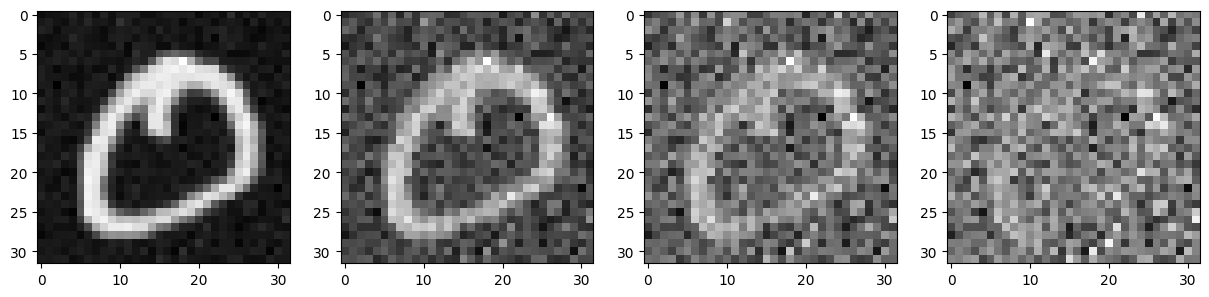

In [7]:
sample_mnist = next(iter(train_ds))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 50, 100, 185]):
  noisy_im, noise = forward_noising(random.PRNGKey(0), jnp.expand_dims(sample_mnist, 0), jnp.array([i,]))
  plt.subplot(1, 4, index+1)
  plt.imshow(jnp.squeeze(jnp.squeeze(noisy_im, -1),0), cmap='gray')

plt.show()

In [8]:
class SinusoidalEmbedding(nn.Module):
  dim: int = 32
  
  @nn.compact
  def __call__(self, inputs):
    half_dim = self.dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim) * -emb)
    emb = inputs[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], -1)
    return emb


class TimeEmbedding(nn.Module):
  dim: int = 32
  @nn.compact
  def __call__(self, inputs):
    time_dim = self.dim * 4
    
    se = SinusoidalEmbedding(self.dim)(inputs)
    
    x = nn.Dense(time_dim)(se)
    x = nn.gelu(x)
    x = nn.Dense(time_dim)(x)
    
    return x

In [9]:
class Attention(nn.Module):
    dim: int
    num_heads: int = 8
    use_bias: bool = False
    kernel_init: Callable = nn.initializers.xavier_uniform()

    @nn.compact
    def __call__(self, inputs):
        batch, h, w, channels = inputs.shape
        inputs = inputs.reshape(batch, h*w, channels)
        batch, n, channels = inputs.shape
        scale = (self.dim // self.num_heads) ** -0.5
        qkv = nn.Dense(
            self.dim * 3, use_bias=self.use_bias, kernel_init=self.kernel_init
        )(inputs)
        qkv = jnp.reshape(
            qkv, (batch, n, 3, self.num_heads, channels // self.num_heads)
        )
        qkv = jnp.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        attention = (q @ jnp.swapaxes(k, -2, -1)) * scale
        attention = nn.softmax(attention, axis=-1)

        x = (attention @ v).swapaxes(1, 2).reshape(batch, n, channels)
        x = nn.Dense(self.dim, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.reshape(x, (batch, int(x.shape[1]** 0.5), int(x.shape[1]** 0.5), -1))
        return x

In [10]:
class Block(nn.Module):
  dim: int = 32
  groups: int = 8

  @nn.compact
  def __call__(self, inputs):
    conv = nn.Conv(self.dim, (3, 3))(inputs)
    norm = nn.GroupNorm(num_groups=self.groups)(conv)
    activation = nn.silu(norm)
    return activation


class ResnetBlock(nn.Module):
  dim: int = 32
  groups: int = 8

  @nn.compact
  def __call__(self, inputs, time_embed=None):
    x = Block(self.dim, self.groups)(inputs)
    if time_embed is not None:
      time_embed = nn.silu(time_embed)
      time_embed = nn.Dense(self.dim)(time_embed)
      x = jnp.expand_dims(jnp.expand_dims(time_embed, 1), 1) + x
    x = Block(self.dim, self.groups)(x)
    res_conv = nn.Conv(self.dim, (1, 1), padding="SAME")(inputs)
    return x + res_conv

In [11]:
class UNet(nn.Module):
  dim: int = 8
  dim_scale_factor: tuple = (1, 2, 4, 8)
  num_groups: int = 8


  @nn.compact
  def __call__(self, inputs):
    inputs, time = inputs
    channels = inputs.shape[-1]
    x = nn.Conv(self.dim // 3 * 2, (7, 7), padding=((3,3), (3,3)))(inputs)
    time_emb = TimeEmbedding(self.dim)(time)
    
    dims = [self.dim * i for i in self.dim_scale_factor]
    pre_downsampling = []
    
    for index, dim in enumerate(dims):
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      att = Attention(dim)(x)
      norm = nn.GroupNorm(self.num_groups)(att)
      x = norm + x

      pre_downsampling.append(x)
      if index != len(dims) - 1:
        x = nn.Conv(dim, (4,4), (2,2))(x)
    
    x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
    att = Attention(dim)(x)
    norm = nn.GroupNorm(self.num_groups)(att)
    x = norm + x 
    x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
    
    for index, dim in enumerate(reversed(dims)):
      x = jnp.concatenate([pre_downsampling.pop(), x], -1)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      att = Attention(dim)(x)
      norm = nn.GroupNorm(self.num_groups)(att)
      x = norm + x
      if index != len(dims) - 1:
        x = nn.ConvTranspose(dim, (4,4), (2,2))(x)

    x = ResnetBlock(dim, self.num_groups)(x, time_emb)
    x = nn.Conv(channels, (1,1), padding="SAME")(x)
    return x

model = UNet(32)

In [12]:
@jax.jit
def apply_model(state, noisy_images, noise, timestamp):
  """Computes gradients and loss for a single batch."""
  def loss_fn(params):
    
    pred_noise = model.apply({'params': params}, [noisy_images, timestamp])
    
    loss = jnp.mean((noise - pred_noise) ** 2)
    return loss

  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=False)
  loss, grads = grad_fn(state.params)
  return grads, loss


@jax.jit
def update_model(state, grads):
  """Applies gradients to the model"""
  return state.apply_gradients(grads=grads)

In [13]:
def train_epoch(epoch_num, state, train_ds, batch_size, rng):

  epoch_loss = []

  for index, batch_images in enumerate(tqdm(train_ds)):
    rng, tsrng = random.split(rng)
    
    timestamps = random.randint(tsrng, 
                                shape=(batch_images.shape[0],), 
                                minval=0, maxval=timesteps)
    
    noisy_images, noise = forward_noising(rng, batch_images, timestamps)
    
    grads, loss = apply_model(state, noisy_images, noise, timestamps)
    
    state = update_model(state, grads)
    
    epoch_loss.append(loss)
    if index % 100 == 0:
      print(f"Loss at step {index}: ", loss)
    
    del timestamps 
  
  train_loss = np.mean(epoch_loss)


  return state, train_loss

In [14]:
from flax.training import train_state

def create_train_state(rng):
  """Creates initial `TrainState`."""
  
  params = model.init(rng, [jnp.ones([1, 32, 32, 1]), jnp.ones([1,])])['params']
  
  tx = optax.adam(1e-4)
   
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [15]:
log_state = []

def train(train_ds) -> train_state.TrainState:
  rng = jax.random.PRNGKey(0)
  
  rng, init_rng = jax.random.split(rng)
    
  state = create_train_state(init_rng)
  
  for epoch in range(1, NUM_EPOCHS + 1):
    rng, input_rng = jax.random.split(rng)
    
    state, train_loss = train_epoch(epoch, state, train_ds, BATCH_SIZE, input_rng)
    
    print(f"Training loss after epoch {epoch}: ", train_loss)
    log_state.append(state) # Optional

  return state

In [21]:
trained_state = train(train_ds)

  0%|          | 0/235 [00:00<?, ?it/s]

Loss at step 0:  

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error preparing computation: %sOut of memory allocating 56741052416 bytes.

In [ ]:
# This function defines the logic of getting x_t-1 given x_t
def backward_denoising_ddpm(x_t, pred_noise, t):
  alpha_t = jnp.take(alpha, t)
  alpha_t_bar = jnp.take(alpha_bar, t)
  
  eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5  
  mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * pred_noise)
  
  var = jnp.take(beta, t)
  z = random.normal(key=random.PRNGKey(r.randint(1, 100)), shape=x_t.shape)

  return mean + (var ** 0.5) * z

In [ ]:
# Save a GIF using logged images

def save_gif(img_list, path=""):
    # Transform images from [-1,1] to [0, 255]
    imgs = (Image.fromarray(np.array((np.array(i) * 127.5) + 1, np.int32)) for i in img_list)

    # Extract first image from iterator
    img = next(imgs)  

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [ ]:
# Generating Gaussian noise
x = random.normal(random.PRNGKey(42), (1, 32, 32, 1))

trained_state = log_state[-1]

# Create a list to store output images
img_list_ddpm = []

# Append the initial noise to the list of images
img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# Iterate over T timesteps
for i in tqdm(range(0, timesteps - 1)):
  # t-th timestep  
  t = jnp.expand_dims(jnp.array(timesteps - i - 1, jnp.int32), 0)
  
  # Predict noise using U-Net
  pred_noise = model.apply({'params': trained_state.params}, [x, t])
  
  # Obtain the output from the noise using the formula seen before
  x = backward_denoising_ddpm(x, pred_noise, t)

  # Log the image after every 25 iterations
  if i % 25 == 0:
    img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))
    plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
    plt.show()

# Display the final generated image
plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
plt.show()

# Save generated GIF
save_gif(img_list_ddpm, path="output_ddpm.gif")

In [ ]:
# Display GIF
display.Image(url='output_ddpm.gif', width=128, height=128)